In [1]:
import pandas as pd
import numpy as np
import teetool as tt
import os
import matplotlib.pyplot as plt

/home/will/anaconda3/envs/teetool/lib/python2.7/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


In [2]:
file_trajectories = "app.csv"
#file_trajectories = "dep.csv"

In [3]:
def getFile(fileName):
    """
    downloads file if not yet done so
    """
    
    locale_path = "data/{0}".format(fileName)
    online_path = "https://www.southampton.ac.uk/~wje1n13/camrocsim/{0}".format(fileName)
    
    if not os.path.isfile(locale_path):
        !wget $online_path -O $locale_path

In [4]:
getFile(file_trajectories)

In [5]:
# read data
df = pd.read_csv("data/{0}".format(file_trajectories))

# rename columns
df.rename(columns={'EASTINGS_M': 'x [m]',
                   'NORTHINGS_M': 'y [m]',
                   'ALTITUDE_M': 'z [m]'}, inplace=True)





In [6]:
# normalise dimensions? reasonable plotting

# normalise x y z GLOBALLY (all trajectories)
these_cells_input = ["x [m]", "y [m]", "z [m]"]
these_cells_output = ["x [-]", "y [-]", "z [-]"]

for (i, cell_input) in enumerate(these_cells_input):
    cell_output = these_cells_output[i]
    df.loc[:,cell_output] = (df[cell_input] - df[cell_input].min()) / ( df[cell_input].max() - df[cell_input].min() )


df.head()

,CLUSTER_ID,TRAJECTORY_ID,y [m],x [m],z [m],x [-],y [-],z [-]
0,1,0,338415,268895,956,0.718833,0.986451,0.541792
1,1,0,337608,268677,947,0.716839,0.979087,0.536380
2,1,0,336794,268496,938,0.715182,0.971660,0.530968
3,1,0,335940,268481,929,0.715045,0.963868,0.525556
4,1,0,335177,268249,929,0.712922,0.956907,0.525556


In [7]:
# flick data into arrays

cluster_data_list = []

for cluster_id in df.CLUSTER_ID.unique():
    # pass all clusters
    
    dfc = df[df["CLUSTER_ID"] == cluster_id]
    
    cluster_data = []

    for trajectory_id in dfc.TRAJECTORY_ID.unique():
        # pass all trajectories IN this cluster

        # extract values
        dft = dfc[dfc["TRAJECTORY_ID"] == trajectory_id]

        Yn = np.array([dft["x [-]"].values, dft["y [-]"].values, dft["z [-]"].values]).transpose()
        
        (npoints, ndim) = Yn.shape
        
        # assume linearly distributed points (no indication otherwise)
        xn = np.linspace(0, 1, npoints)

        # add tuple to list
        cluster_data.append((xn, Yn))
    
    cluster_data_list.append(cluster_data)

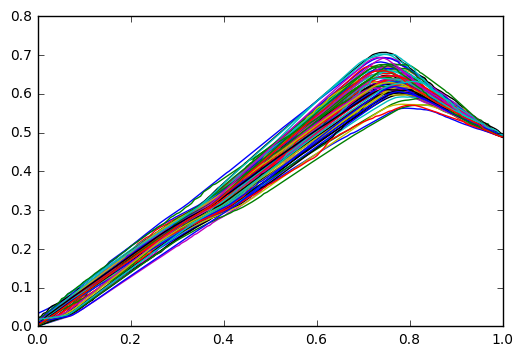

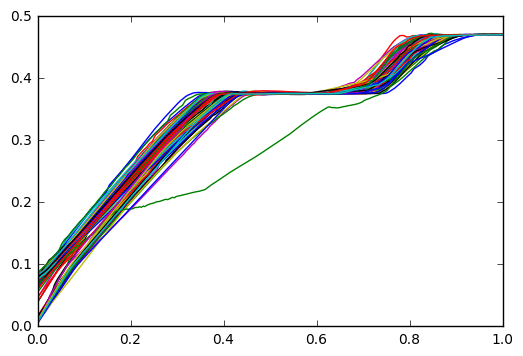

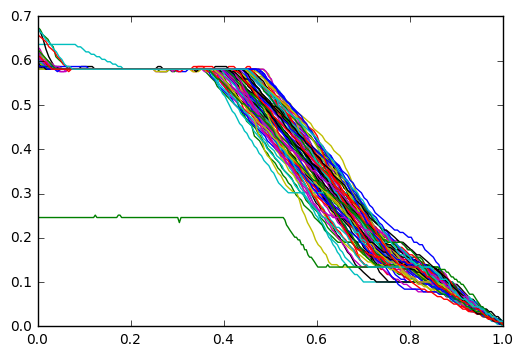

In [8]:
%matplotlib inline

cluster_data = cluster_data_list[2]

for d in [0, 1, 2]:
    fig = plt.figure()
    ax = fig.gca()
    for (xn, Yn) in cluster_data:
        ax.plot(xn, Yn[:,d])

In [9]:
# start modelling

# build world
new_world = tt.World(name="DFW", ndim=3)

# modify default resolution
new_world.setResolution(xstep=20, ystep=20, zstep=20)

for i, cluster_data in enumerate(cluster_data_list):
    new_world.addCluster(cluster_data, "c {0}".format(i))

# overview
new_world.overview()

# alter area (slightly larger)
new_world.fraction_to_expand = 0.1

# settings
#settings = {"model_type":"EM", "ngaus":100, "basis_type":"rbf", "nbasis":15}
settings = {"model_type":"resampling", "ngaus":100}

# model
for i, cluster_data in enumerate(cluster_data_list):
    new_world.buildModel(i, settings)

new_world.overview()  # overview

# log
for i, cluster_data in enumerate(cluster_data_list):
    new_world.buildLogProbality(i)
    new_world.overview()  # overview

*** overview [DFW] ***
0 [c 0] [-] [-]
1 [c 1] [-] [-]
2 [c 2] [-] [-]
3 [c 3] [-] [-]
4 [c 4] [-] [-]
5 [c 5] [-] [-]
6 [c 6] [-] [-]
7 [c 7] [-] [-]
*** overview [DFW] ***
0 [c 0] [*] [-]
1 [c 1] [*] [-]
2 [c 2] [*] [-]
3 [c 3] [*] [-]
4 [c 4] [*] [-]
5 [c 5] [*] [-]
6 [c 6] [*] [-]
7 [c 7] [*] [-]
number of calculations: 5000
....
number of calculations: 8000
......
*** overview [DFW] ***
0 [c 0] [*] [*]
1 [c 1] [*] [-]
2 [c 2] [*] [-]
3 [c 3] [*] [-]
4 [c 4] [*] [-]
5 [c 5] [*] [-]
6 [c 6] [*] [-]
7 [c 7] [*] [-]
number of calculations: 5000
....
number of calculations: 8000
......
*** overview [DFW] ***
0 [c 0] [*] [*]
1 [c 1] [*] [*]
2 [c 2] [*] [-]
3 [c 3] [*] [-]
4 [c 4] [*] [-]
5 [c 5] [*] [-]
6 [c 6] [*] [-]
7 [c 7] [*] [-]
number of calculations: 5000
....
number of calculations: 8000
......
*** overview [DFW] ***
0 [c 0] [*] [*]
1 [c 1] [*] [*]
2 [c 2] [*] [*]
3 [c 3] [*] [-]
4 [c 4] [*] [-]
5 [c 5] [*] [-]
6 [c 6] [*] [-]
7 [c 7] [*] [-]
number of calculations: 5000
....
n

In [11]:
# plotting trajectories

these_clusters = range(8)

# visuals by mayavi
visual = tt.visual_3d.Visual_3d(new_world)
# visualise trajectories
visual.plotTrajectories(these_clusters)
# visualise outline
visual.plotOutline()

In [12]:
# plotting iso surface

# visuals by mayavi
visual = tt.visual_3d.Visual_3d(new_world)
# visualise iso surface
visual.plotLogIsoSurface(these_clusters, pcontours=[.99])
# visualise outline
visual.plotOutline()
# wait to close
visual.show()